In [9]:
import torch
import torch.nn as nn
import numpy as np
import random
from collections import namedtuple, deque

In [10]:
BUFFER_SIZE   = int(1e5)
BATCH_SIZE    = 64
GAMMA         = 0.99 # discount factor
TAU           = 1e-3 # soft update of target parameter
LEARNING_RATE = 5e-4
UPDATE_EVERY  = 4    # how often to update the target

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
from Board import Board
env = Board()

In [13]:
class QNetwork(nn.Module):
    """ Agent Policy Network Model """
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x:torch.Tensor):
        """ state -> action values """
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.fc3(x)
        return x


In [14]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(16, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 4),
)
state = torch.from_numpy(np.array([12]*2*16).reshape(2,4,4)).float()
print(model(state))


tensor([[ 1.3308, -1.2016, -2.2130,  0.0137],
        [ 1.3308, -1.2016, -2.2130,  0.0137]], grad_fn=<AddmmBackward0>)


In [15]:
q = QNetwork(16,4)
state = torch.from_numpy(np.array(list(range(16))*2).reshape(2,4,4)).float()
# print(state)
print(state.shape)
print(q(state))

torch.Size([2, 4, 4])
tensor([[ 0.4888, -0.2790, -0.6392, -0.2105],
        [ 0.4888, -0.2790, -0.6392, -0.2105]], grad_fn=<AddmmBackward0>)


In [16]:
# batch = torch.from_numpy(np.array([12]*16*BATCH_SIZE).reshape(4,4,BATCH_SIZE)).float().unsqueeze(0)
# print(batch)
# print(q(batch))

In [17]:
class ReplayBuffer:
    """ Fixed size buffer to store experience tuples """

    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experience = namedtuple('experience', field_names=[
                                     'state', 'action', 'reward', 'next_state', 'done'])
        self.memory: deque[self.experience] = deque(maxlen=buffer_size)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """  """
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(
            np.stack([e.state for e in experiences if e is not None], axis=0)).to(device).float()
        actions = torch.from_numpy(
            np.stack([e.action for e in experiences if e is not None], axis=0)).to(device).float()
        rewards = torch.from_numpy(
            np.stack([e.reward for e in experiences if e is not None], axis=0)).to(device).float()
        next_states = torch.from_numpy(
            np.stack([e.next_state for e in experiences if e is not None], axis=0)).to(device).float()
        dones = torch.from_numpy(np.stack(
            [e.done for e in experiences if e is not None], axis=0).astype(np.uint8)).to(device).float()
        return self.experience(states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [18]:
b=ReplayBuffer(4, BUFFER_SIZE, BATCH_SIZE)
for i in range(100):
    b.add(np.array([12.3]*16).reshape(4,4),0,3,np.array([12.3]*16).reshape(4,4),False)

In [19]:
t=random.sample(b.memory, k=b.batch_size)
a = torch.cat(tuple((torch.tensor(e.state, device=device) for e in t if e is not None)),-1).to(device).float()
a.shape
# torch.tensor(t[-1].state).shape

# tuple((e.state for e in t if e is not None))

torch.Size([4, 256])

In [20]:
b.sample()

experience(state=tensor([[[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        ...,

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 

In [21]:
b.sample().state

tensor([[[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        ...,

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000,

In [22]:
class Agent:
    def __init__(self, state_size, action_size, learning_rate):
        self.state_size = state_size
        self.action_size = action_size

        self.qnetwork_local = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)
        self.optimizer = torch.optim.Adam(
            self.qnetwork_local.parameters(), lr=learning_rate)
        # replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)

        self.time_step = 0
        self.eps = 0.0
        self.gamma = 0.9

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.time_step += 1 
        if self.time_step % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                experience = self.memory.sample()
                self.learn(experience)

    def act(self, state, eps=0.0, train=True)->int:
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        """ (w,h)->(1,w,h) Add one dimension to the state, as the nn expect a batch.  """
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state).to(device)
        self.qnetwork_local.train()
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy()) #  "addmm_cuda" not implemented for 'Long'
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experience):
        """ Update parameters using batch of experience tuples """
        states, actions, rewards, next_states, dones = experience
        q_targets_next = self.qnetwork_target(
            next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards+self.gamma*q_targets_next*(1-dones)
        q_expected = self.qnetwork_local(states).gather(1, actions.type(torch.int64).unsqueeze(1)).squeeze(1)
        # Compute the loss and gradient
        loss = torch.nn.functional.mse_loss(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def state_to_features(self, state: np.ndarray):
        return torch.from_numpy(state.flatten()).to(device).float().unsqueeze(0)


    def soft_update(self, local_model, target_model, tau):
        """ θ_target = τ*θ_local + (1 - τ)*θ_target 
        copy the weights of the local model to the target model
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(
                tau*local_param.data+(1.0-tau)*target_param.data)

In [23]:
a=Agent(16, 4, LEARNING_RATE)

In [24]:
a.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.0005
    maximize: False
    weight_decay: 0
)

In [25]:
a.step(np.array([123]*16),0,3,np.array([123]*16),False)

In [26]:
a.act(np.array(list(range(16))).reshape(4,4))

2

In [27]:
state = torch.tensor(np.array(list(range(16))).reshape(4,4)).float()
print(state)
state = state.unsqueeze(0)
print('added dimension',state)
print(a.qnetwork_target(state))
print(torch.argmax(a.qnetwork_target(state)))


tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
added dimension tensor([[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]])
tensor([[-0.6072, -1.4731,  0.7984,  0.9461]], grad_fn=<AddmmBackward0>)
tensor(3)


In [28]:
torch.argmax(torch.tensor([[ 0.1125,  0.1978,  0.0226, -0.2571]]))

tensor(1)

In [29]:
b.sample()

experience(state=tensor([[[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        ...,

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000],
         [12.3000, 12.3000, 12.3000, 12.3000]],

        [[12.3000, 

In [30]:
b.sample().state.shape

torch.Size([64, 4, 4])

In [31]:
a.learn(b.sample())

C:\Users\felixwong\AppData\Local\Temp\ipykernel_27584\1803496910.py:45: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(q_expected, q_targets)


In [32]:
def train(agent: Agent, n_episodes, max_time_step, eps_start, eps_end, eps_decay):
    scores = []
    num_rounds = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for episode in range(n_episodes):
        env.reset()
        state = env.board
        score = 0
        rounds = 0
        for time_step in range(max_time_step):
            action = agent.act(state, eps)
            next_state, reward, done = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            rounds += 1
            if done:
                break
        scores_window.append(score)
        scores.append(score)
        num_rounds.append(rounds)
        eps = max(eps_end, eps-eps_decay)
        if episode % 100 == 0:
            print(episode, np.mean(scores_window))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pt')
    return scores, num_rounds

In [33]:
agent = Agent(state_size=16, action_size=4, learning_rate=LEARNING_RATE)
scores, num_rounds = train(agent, n_episodes=100, max_time_step=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.01)


C:\Users\felixwong\AppData\Local\Temp\ipykernel_27584\1803496910.py:45: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(q_expected, q_targets)


0 189.0


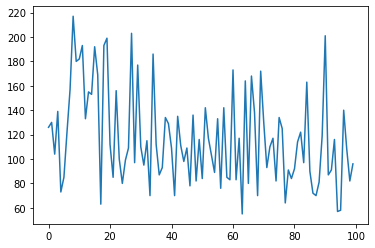

In [44]:
import matplotlib.pyplot as plt
plt.plot(num_rounds)

(array([ 9., 19., 15., 18., 12.,  6.,  7.,  6.,  5.,  3.]),
 array([ 55. ,  71.2,  87.4, 103.6, 119.8, 136. , 152.2, 168.4, 184.6,
        200.8, 217. ]),
 <BarContainer object of 10 artists>)

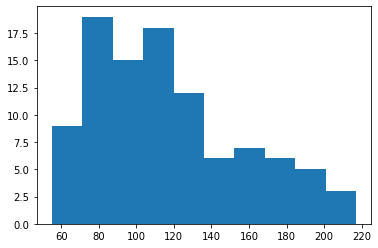

In [36]:
plt.hist(num_rounds)

In [38]:
np.percentile(num_rounds,50)

110.5